In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import os
import pandas as pd
from PIL import Image
import seaborn as sb
from statsmodels.tsa.seasonal import STL
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
import torchvision
from torchvision import transforms
import urllib
#------------------
from dataset import TimeSeriesDataset
from models import MLR, MLP
from resnet_family import resnet20_cifar
from utils_cm import compute_cm

## Load the CO2 Concentration Dataset

Source: https://github.com/yaringal/DropoutUncertaintyCaffeModels/tree/master/co2_regression/data

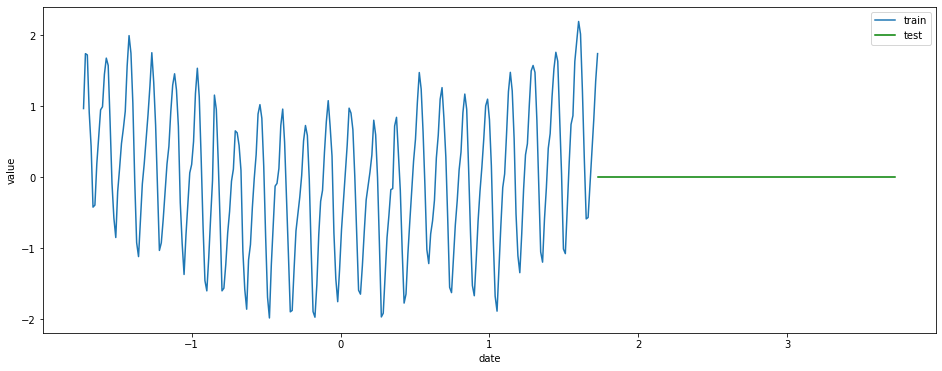

In [2]:
import h5py

with h5py.File("data/co2/co2_train.h5", "r") as f:
    keys = list(f.keys())
    date = np.array(f[keys[0]]).reshape(-1, 1)
    value = np.array(f[keys[1]]).reshape(-1, 1)
    signal_train = pd.DataFrame(np.hstack([date, value]), columns=['date', 'value'])

with h5py.File("data/co2/co2_test.h5", "r") as f:
    keys = list(f.keys())
    date = np.array(f[keys[0]]).reshape(-1, 1)
    value = np.array(f[keys[1]]).reshape(-1, 1) * 0
    signal_test = pd.DataFrame(np.hstack([date, value]), columns=['date', 'value'])
    
fig, ax = plt.subplots(1, 1, figsize=(16, 6))
sb.lineplot(ax=ax, x='date', y='value', data=signal_train, label='train')
sb.lineplot(ax=ax, x='date', y='value', color='g', data=signal_test, label='test')
ax.legend()
# sb.lineplot(ax=ax[1], x='date', y='value', color='g', data=signal_test, label='test')
ax.legend();

In [3]:
# stl = STL(train_labels, period=12, seasonal=7)
# stl_result = stl.fit()
# stl_result.plot()

In [4]:
train_labels = signal_train.value
train_data = np.hstack([signal_train.date.to_numpy().reshape(-1, 1)])
test_labels = signal_test.value
test_data = np.hstack([signal_test.date.to_numpy().reshape(-1, 1)])

In [5]:
train_data.shape, test_data.shape

((272, 1), (1000, 1))

((272, 1), (272,))

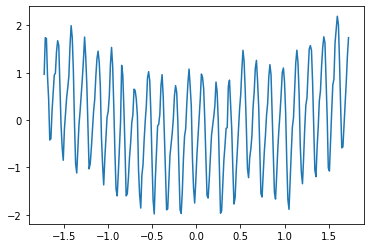

In [6]:
# test_data = train_data
# test_labels = train_labels

batch_size = 256
train_loader = DataLoader(TimeSeriesDataset(train_data, train_labels), batch_size=batch_size, shuffle=True)
test_loader = DataLoader(TimeSeriesDataset(test_data, test_labels), batch_size=batch_size, shuffle=False)
plt.plot(train_data, train_labels)
train_data.shape, train_labels.shape

## [Training Model and Configuration](#Training-Model-and-Configuration)

In [7]:
hidden_layers = [100, 100, 100, 100]
dropout = 0.1
lr = 0.001
tau = 1
wd = 0.000005 #  0.01**2 * (1 - dropout) / (2. * len(train_loader) * tau)

model = MLR(input_size=train_data.shape[1], nclasses=1, hidden_layers=hidden_layers, dropout=dropout, batch_norm=True)
optimizer = torch.optim.SGD(model.parameters(), lr=lr, momentum=0.99, weight_decay=wd)
model.net

Sequential(
  (0): Linear(in_features=1, out_features=100, bias=True)
  (1): ReLU()
  (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=100, out_features=100, bias=True)
  (5): ReLU()
  (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.1, inplace=False)
  (8): Linear(in_features=100, out_features=100, bias=True)
  (9): ReLU()
  (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (11): Dropout(p=0.1, inplace=False)
  (12): Linear(in_features=100, out_features=100, bias=True)
  (13): ReLU()
  (14): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (15): Dropout(p=0.1, inplace=False)
  (16): Linear(in_features=100, out_features=1, bias=True)
)

In [8]:
lr = 0.0001
for param_group in optimizer.param_groups:
    param_group['lr'] = lr

In [9]:
%%script false --no-raise-error
# The above statement skips this cell

reset_loss_every = 100
n_epochs = 200000
device = "cpu"
model.to(device)
model.train()

def set_bn_eval(module):
    if isinstance(module, torch.nn.modules.batchnorm._BatchNorm):
        module.eval()

for epoch in range(n_epochs+1):
    loss_epoch = 0
    num_samples = 0
    
    model.train()
    for it, batch in enumerate(train_loader):
        data, target = batch
        
        if len(target) < batch_size:
#             print(f"it: {it} -> eval mode for BN")
#             model.apply(set_bn_eval)
            continue

        optimizer.zero_grad()
        output = model(data.float().to(device))
        loss = F.mse_loss(output, target.view(-1, 1).to(device))
        num_samples += len(target)
        loss_epoch += loss.item() * len(target)
        loss.backward()
        optimizer.step()
        
    print(f"epoch: {epoch}, num_samples: {num_samples}, average_loss: {loss_epoch / num_samples}")
    
    if (epoch % (n_epochs//2)) == 0 and epoch > 0:
        lr *= 0.5
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

# Save the model and weights
checkpoint = {'model': model,
              'state_dict': model.state_dict(),
              'optimizer' : optimizer.state_dict()}
torch.save(checkpoint, './weights/checkpoint.pth')

### Enable DropOut during evaluation

In [10]:
model = torch.load('./weights/checkpoint_co2_dataset_200k.pth')['model']

In [11]:
def train_mode_dropout(m):
    if type(m) == torch.nn.Dropout:
        m.train()
model.eval()
model.apply(train_mode_dropout)

MLR(
  (net): Sequential(
    (0): Linear(in_features=1, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): Dropout(p=0.1, inplace=False)
    (4): Linear(in_features=100, out_features=100, bias=True)
    (5): ReLU()
    (6): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (7): Dropout(p=0.1, inplace=False)
    (8): Linear(in_features=100, out_features=100, bias=True)
    (9): ReLU()
    (10): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (11): Dropout(p=0.1, inplace=False)
    (12): Linear(in_features=100, out_features=100, bias=True)
    (13): ReLU()
    (14): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (15): Dropout(p=0.1, inplace=False)
    (16): Linear(in_features=100, out_features=1, bias=True)
  )
)

### Evaluate

(1000,)


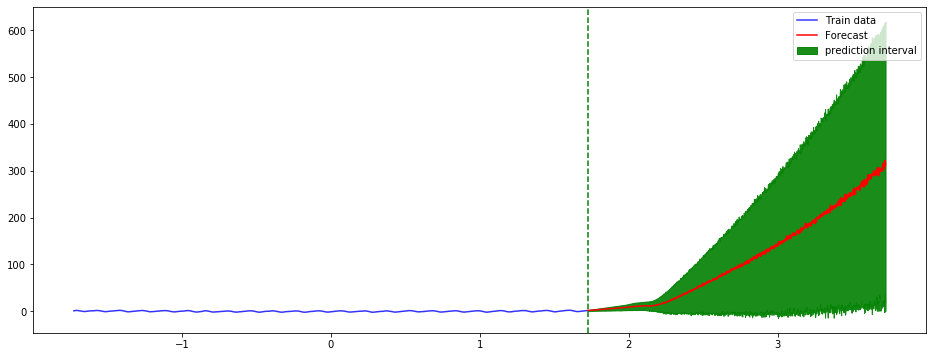

In [12]:
device = "cpu"
model.to(device)
ensemble_size = 1000

gt = []
forecast = []
for it, batch in enumerate(test_loader):
    data, target = batch
    output = []
    for ensemble_it in range(ensemble_size):
        output.append(model(data.float().to(device)).data.numpy())
    output = np.hstack(output)
    forecast.append(output)
    gt.append(target.view(-1).data.numpy())
    
forecast = np.vstack(forecast)
predictive_mean = forecast.mean(1)
predictive_std = forecast.std(1)
print(predictive_mean.shape)
# print(predictive_std)
gt = np.hstack(gt)
mse_loss = ((gt - predictive_mean)**2).mean()
# print(f"Test mse_loss = {mse_loss}")

fig, axes = plt.subplots(figsize=(16, 6))
axes.plot(train_data.squeeze(), train_labels.squeeze(), 'b', label="Train data", alpha=0.8);
axes.axvline(train_data.squeeze()[-1], color='g',linestyle='--');
axes.plot(test_data.squeeze(), predictive_mean, color='r', label="Forecast")
axes.fill_between(test_data.squeeze(), predictive_mean-2*predictive_std, predictive_mean+2*predictive_std, label='prediction interval', color='g', alpha=0.9);
axes.legend();

Repeat the above training+evaluation experiment for two different values of DropourRate={0, 0.1} in the [Training-Model-and-Configuration](http://localhost:8888/notebooks/uncertainty_regression.ipynb#Training-Model-and-Configuration) cell (above) and see how that single change introduces the prediction interval.

##### References: 
[What My Deep Model Doesn't Know](http://mlg.eng.cam.ac.uk/yarin/blog_3d801aa532c1ce.html)

[Dropout as a Bayesian Approximation:
Representing Model Uncertainty in Deep Learning](http://proceedings.mlr.press/v48/gal16.pdf)

[Dropout as Regularization and Bayesian Approximation](https://xuwd11.github.io/Dropout_Tutorial_in_PyTorch/)